# Generating Spin-Spirals using Rydberg atoms

Reet Mhaske, Indian Institute of Technology Bombay 

email:mhaskereet@gmail.com 

Guide: Prof Matthias Weidemuller


Special Thanks: 

Eduard Braun and Sebastian Geir for discussions over the code


To whoever uses the code in the group:

Feel free to contact in case of any discrepancies, corrections or clarifications for the code


## Abstract

We identify the most suitable two levels in a Rydberg atom, under electric and magnetic field, that can be used to generate spin spirals. Various factors like gradient of energy vs electric field, the maximum linear region, energy difference between the chosen states, electric dipole, spiralization time, and the electric field at this optimal point need to be considered, so that they meet the experimental feesibility/constraints. Once the ideal electric field is identified, we then find the C3 coefficient matrix at this field. After that we map the resulting Hamiltonian to a spin model, and plot the resulting coefficients.



# Units and convention

All energies/frequencies in GHz unless otherwise specified. The standrad units of pair interaction are followed.



Lines with " # " are comments by the author of the code.

Lines with " ## " can be uncommented if needed for printing/additional modifications of the code as mentioned in the comments below them

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from pairinteraction import pireal as pi
import scipy
import csv

In [5]:
# for accessing pair interaction functions

if not os.path.exists("./cache"):
    os.makedirs("./cache")
cache = pi.MatrixElementCache("./cache")

iota=complex(0,1)

# 1. Generating the Stark Map

We iterate over the range of $E$ electric fields specidied by the array $\textit{array_efield}$ (in $x$ direction)

We operate at $B$ Magnetic field of 160 Gauss, in the $z$ direction

We work with 48 Rb states. For calculations, we consider only those states whose energies lie with $|46s -0.5\rangle $ and$| 50s +0.5\rangle$ levels. Even within this range, principal quantum numbers between $\textit{N_upper}$ and $\textit{N_lower}$ and with angular momentum levels (as defined at zero electric fields) only upto $\textit{l_lim}$ are considered.  

At each electric field,we identify the eigenstates with the maximum overlap with the unperturbed states, and extract them and call them by the labels of the unperturbed states. 


For example, at electric field $E_0$, we find which eigenstate of the Hamiltonina at that field has maximum overlap with say 4P state, and then call that state as the 4P state at electric field $E_0$. In this way, we can find the pseudo "evolution" of the 4P state with electric field.  


# Identifying the indices of the states of interest

the array "labels" holds the labels of the states of n=48 that we are interested in, but the ones taht satisfy the energy and l constraint set up above,

It stores each element in the form (L,J,m_j), in increasing L

In [9]:
array_efield = np.linspace(0, 4, 1000)# V/cm #the range of electric fields
  
# Initialize a system comprising one rubidium Rydberg atom
system = pi.SystemOne("Rb", cache)

# Consider only states with similar energy and quantum numbers as the defined state

N=48
N_upper=N+4  # upper limit on N quantum number of the states being considered
N_lower=N-4
number_of_n_considered=N_upper - N_lower + 1
system.restrictN(N_lower, N_upper)

l_lim=8 # consider only states upto l(orbital quantum number)=8 for diagonalizing the Hamiltonian

# the eigenenergies separately verified to have almost converged for this l

number_of_l_considered=l_lim+1
system.restrictL(0,l_lim) 

state_n_lower=pi.StateOne("Rb",N-2,0,0.5,-0.5)  # the least energy to be considered is that of 46s,-0.5
state_n_higher=pi.StateOne("Rb",N+2,0,0.5,0.5) # the max energy to be considered is that of 50s,+0.5

E_lower_lim=state_n_lower.getEnergy()
E_upper_lim= state_n_higher.getEnergy()
##print(E_upper_lim)
##print()
system.restrictEnergy(E_lower_lim, E_upper_lim) # limit the energies being considered

# Set magnetic field
system.setBfield([ 0,0,160])

labels=[] 
# thi will store labels of the unperturbed states being considered (that meet the restriction on N,l and energy) 
# ... in the form (L,J,m_j), in increasing order of L
# (only upto l=5)


print(np.shape(system.getHamiltonian()))

##print(number_of_n_considered*(2*(number_of_l_considered)**2))

Hamiltonian_matrix_dim = np.shape(system.getHamiltonian())[0]
dim=Hamiltonian_matrix_dim
for l_ in np.arange(start=0,stop=5,step=1):
      for j_ in np.arange(abs(l_-0.5),l_+0.5+0.001,1):
            for mj_ in np.arange(-j_,j_+1,1):
                ##print(l_,j_,mj_)

                state = pi.StateOne("Rb", int(N), int(l_), float(j_),float( mj_))
                if (state.getEnergy()< E_upper_lim and state.getEnergy()>E_lower_lim):
                    #state_indices.append(np.argmax(system.getOverlap(state)))
                    labels.append((l_,j_,mj_))

                    # the ordering of labels is used later to identify the states

                    # All states that lie in the energy range that is restricted

# Diagonalize the Hamiltonian of the system for different E-fields
print("Dimension of Hamiltonian :", Hamiltonian_matrix_dim)



(502, 502)
Dimension of Hamiltonian : 502


# Generate Stark Map Data
Find the eigenvalues of  the electric field dependent Hamiltonian over a range of eletric fields

The eigenenergies will be stored in "array_eigenvalues_1", 
which is of same length as "array_efield".
Each element of "array_eigenvalues_1" is an array with length = dim of Hamiltonian (no. of eigenvalues).


We also keep a track of states with max overlpas with the unperturbed states, via the array "states_indices". 
"state_indices" has length of "array_efield", and each element is array of numbers which are indices.


##### state_indices[i][j] stores the index of that eigenstate of Hamiltonan at electric field array_efield[i], which has maximum overlap with the unperturbed state labels[j] for the quantum number N. 


N by default is 48

The eigenenergy corresponding to the state state_indices[i] would be array_eigenvalues_1[i][j]

The data can also be downloaded as a csv from https://github.com/ReetMhaske/Spin-Spiral-States/blob/main/array_eigenvalues_1.csv, and https://github.com/ReetMhaske/Spin-Spiral-States/blob/main/state_indices.csv instead of generating it. (then run the "reading csv" block )


### CREATE STARK MAP AND STORE IN CSV

(The following blocks generate and store the stark map, so that for later analysis one can use the csv that these blocks create. Skip to the block "READ DATA" to load pre-existing data)

In [11]:

# this will generate the stark map
## SKIP IF NOT GENERATING AND STORING DATA! 


e_field_z=0 # our fields are all in x-y plane, 
# for stability analysis of the electrode configuration, this can be changed

#array_overlaps = []
array_eigenvalues_1=np.zeros(shape=(len(array_efield),dim)) # to store eigenvalues
state_indices=[]
overlaps=[]
for efield_index in range(0,len(array_efield)):
    system.setEfield([ array_efield[efield_index],0,e_field_z])
    system.setBfield([ 0,0,160])
    print(np.round(efield_index*100/len(array_efield),2),"percent done",end='\r')
    
    system.diagonalize() # find the eigenvalues of Hamiltonian at this electric field
    
    # Store the eigenenergies
    
    ##print(system.getHamiltonian())
    temp=(system.getHamiltonian().diagonal())
    ##print(np.shape(temp))
    array_eigenvalues_1[efield_index] = np.ravel(temp)
    ##overlaps_temp=[]
    state_indices_temp=[]
    for l_ in np.arange(start=0,stop=5,step=1): # need to extract states with atmost l=5 
        for j_ in np.arange(abs(l_-0.5),l_+0.5+0.001,1):
            for mj_ in np.arange(-j_,j_+1,1):
                ##print(l_,j_,mj_)
                state = pi.StateOne("Rb", int(N), int(l_), float(j_),float( mj_))
                if (state.getEnergy()< E_upper_lim and state.getEnergy()>E_lower_lim):

                    
                    
                    ##if max(system.getOverlap(state)>=0.4):
                      # uncomment the above if loop to to check if the maximum overlapis more than 50percent
                        #if not then the eigenstate is distributed over differenet states , 
                        #so can decide to not take it by adding a statement here 
                        state_indices_temp.append(np.argmax(abs(system.getOverlap(state))))
                        #print(np.max(abs(system.getOverlap(state))))
                        #overlaps_temp.append((max(abs(system.getOverlap(state)))))
                #else:
                     #   state_indices_temp.append(None)
            #        labels.append((l_,j_,mj_))
    state_indices.append(state_indices_temp)
    ##overlaps.append(overlaps_temp)





   ## print(system.getOverlap(state))

    ## Store the overlap of the eigenstates with the defined state
    ##array_overlaps.append(system.getOverlap(state))


##array_eigenvalues_1 = np.ravel(array_eigenvalues_1)
##array_overlaps = np.ravel(array_overlaps)
##array_efield = np.repeat(array_efield, system.getNumBasisvectors())


In [12]:
# SKIP IF NOT GENERATING AND STORING DATA!

# store the eigenvalues at all E fields
import csv
with open('array_eigenvalues_1.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    for index_temp in range(0,len(array_eigenvalues_1)):
        csvwriter.writerow(array_eigenvalues_1[index_temp])
csvfile.close()


In [13]:
# SKIP IF NOT GENERATING AND STORING DATA

# store the generated state_indices 

import csv
with open('state_indices.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter=',')
    for index_temp in range(0,len(state_indices)):
        csvwriter.writerow(state_indices[index_temp])
csvfile.close()

### READ DATA:

In [14]:
# read the stored state_indices
# Make sure the csv is in the same folder as this notebook
state_indices=[]

with open("state_indices.csv", 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        state_indices.append(row)
for convindex in range(len(state_indices)):
    for index2 in range(len(state_indices[convindex])):
        state_indices[convindex][index2]=int(state_indices[convindex][index2])

In [15]:
# read the stored energy eigenvalues

array_eigenvalues_1=[]

with open("array_eigenvalues_1.csv", 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        array_eigenvalues_1.append(row)
for convindex in range(len(array_eigenvalues_1)):
    for index2 in range(len(array_eigenvalues_1[convindex])):
        array_eigenvalues_1[convindex][index2]=float(array_eigenvalues_1[convindex][index2])
array_eigenvalues_1=np.array(array_eigenvalues_1)

# Plot the states 

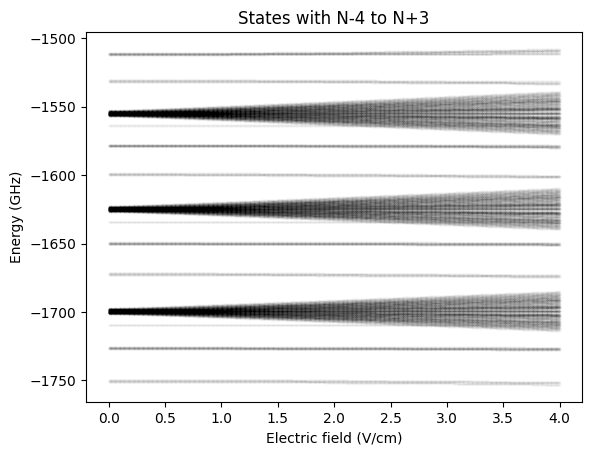

In [16]:
# Plot Stark map, the color code visualizes overlap of eigenstates with defined state
#colors_used = matplotlib.cm.get_cmap('viridis', 2*(number_of_l_considered)**2)

for j in range(0,Hamiltonian_matrix_dim):
    plt.scatter(array_efield,array_eigenvalues_1[:,j],0.0001,label=j,color='k')
plt.xlabel("Electric field (V/cm)")
plt.ylabel("Energy (GHz)")
plt.title("States with N-4 to N+3")
#plt.legend()
#plt.xlim(2.5,4)
#plt.xlim(2.95,3.0)
plt.show()

# Plot the states that correspond to maximum overlap with unperturbed states

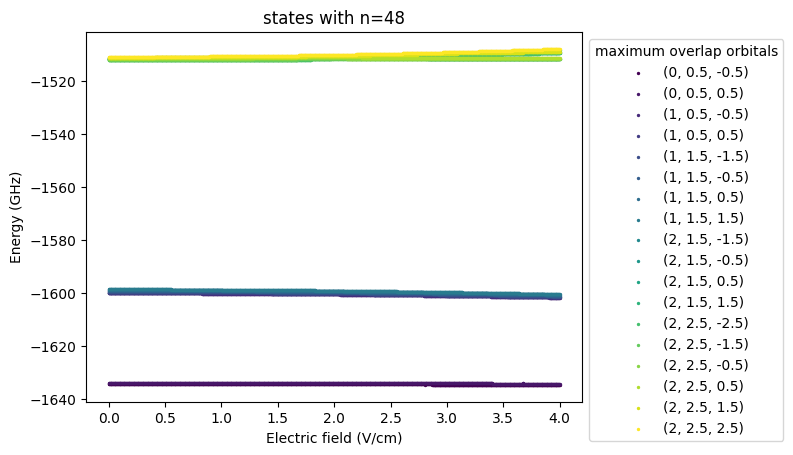

In [18]:
# show the extracted states (the ones stored in the array "label")

eigenstates_of_N=np.zeros(shape=(len(state_indices[0]),len(array_efield)))
# stores the states with the labels

#eigenstates_of_N =np.zeros(shape=((2*(number_of_l_considered)**2),len(array_efield)))
for k in range(0,len(labels)):
    for e in range(0,len(array_efield)):
        #for k in range(0,2*(number_of_l_considered)**2)
        #diff_from_max_overlap=

        #np.abs(array_eigenvalues_1[e][state_indices[e][k]]-array_eigenvalues_1[0][state_indices[e][k]]),abs(np.argmin(np.abs(array_eigenvalues_1[e]-array_eigenvalues_1[0][state_indices[e][k]]))))
        #print(state_indices[e][k])
        #print(array_eigenvalues_1[e][state_indices[e][k]])
        if (state_indices[e][k]==None):
            eigenstates_of_N[k][e]=None
        else:
            eigenstates_of_N[k][e]= array_eigenvalues_1[e][state_indices[e][k]] 
             #np.argmin(# [np.argmin(np.abs(array_eigenvalues_1[e]-array_eigenvalues_1[0][state_indices[k]]))]
#print("done")
colors_used = plt.get_cmap('viridis', len(eigenstates_of_N))

for index in range(0,len(eigenstates_of_N)):
    plt.scatter(array_efield,eigenstates_of_N[index], 2,label=labels[index],color=colors_used((index%len(eigenstates_of_N))))
plt.xlabel("Electric field (V/cm)")
plt.ylabel("Energy (GHz)")
plt.legend(title="maximum overlap orbitals",bbox_to_anchor=(1,1))
plt.title("states with n=48")
#plt.ylim(-1615,-1595)
#plt.xlim(5.5,6)
plt.show()

#if crossing of levels is obsevred, then the labeling must be considered

# Plot of maximal overlap states with the actual states

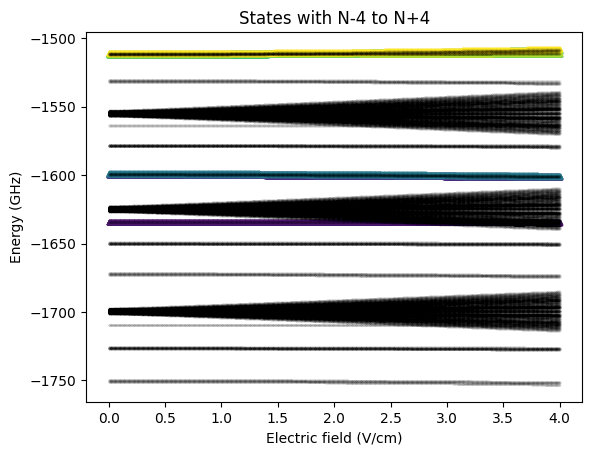

In [19]:
#combine the two plots above in one

for index in range(0,len(eigenstates_of_N)):
    plt.scatter(array_efield,eigenstates_of_N[index], 10,label=labels[index],color=colors_used((index%len(eigenstates_of_N))),marker='^')
for j in range(0,Hamiltonian_matrix_dim):
    plt.scatter(array_efield,array_eigenvalues_1[:,j],0.001,label=j,color='k')
plt.xlabel("Electric field (V/cm)")
plt.ylabel("Energy (GHz)")
plt.title("States with N-4 to N+4")
#plt.legend()
#plt.xlim(2.5,4)
#plt.xlim(4.95,6.0)
#plt.ylim(-1603.5,-1601.5)
plt.show()

# Define functions used later

The functions in this block are used in the actual code. These are kept here for ease of modification. If one wishes, can push them all in another script and import them from that script

In [20]:
# define numerical differentiation

def differentiation(x_data,y_data):
    derivative=np.zeros(shape=(len(y_data),))
    if( len(x_data)!=len(y_data)):
        print("error, x and y dim different")
        return None
    derivative[0] = (y_data[1]-y_data[0])/(x_data[1]-x_data[0])
    derivative[-1] = (y_data[-1]-y_data[-2])/(x_data[-1]-x_data[-2])
    for index in range(1,len(x_data)-1):
        grad_1_temp=(y_data[index+1] -y_data[index])/(x_data[index+1]-x_data[index])
        grad_2_temp=(y_data[index] -y_data[index-1])/(x_data[index]-x_data[index-1])

        if (abs(abs(grad_1_temp)-(abs(grad_2_temp)))>10**-1):
            derivative[index]=None
        else:
            derivative[index]= (y_data[index+1] -y_data[index])/(x_data[index+1]-x_data[index])
    return derivative

# this is not used in this latest version of code, kept here incase one wishes to uncomment parts of the code later, which refer to this function

In [21]:
def length_of_linear_regime(line,y_data,x_data,center_point_index, err=10**-4):
    
    """Input: 
    line=the expected linear fit line (y points only)
    y_data,x_data= the actual data points
    center_point_index= index of the central x point
    all three should be of same length
    
    err= max tolerance in deviation from linear fit line
    
    Returns: the max length (in units same as x_data ) of x_data upto which the linearity holds. 
    
    used to find the linear region in the stark map about a point
    """
    
    # we iterate from center towards the ends and break whenever err bound is crossed
    if((len(line)!=len(y_data)) or ((len(line)!=len(x_data)))or (len(x_data)!=len(y_data))):
        print("error in length of linear_regime(); dim of x_data,y_data,and line should be same")
        return
    deviation=abs(line-y_data)
    temp_max=[]
    max_index= center_point_index
    while (max_index < len(x_data)-1):
        if(deviation[max_index]>err):
            break
        max_index+=1

    min_index=center_point_index
    while (min_index >0 ):
        if(deviation[min_index]>err):
            break
        min_index-=1

    #returns linear regime length
    return abs(x_data[max_index] - x_data[min_index])

# used to find the linear region in the stark map about a point

In [22]:
# redundant, but still kept for completeness

def find_linear_regime(line, y_data,x_data,center_point_index,err=10**-4):
    """essentially same as length_of_linear_regime
    Returns ma linear region, start and end x points of the linear region also
    """
    
    if((len(line)!=len(y_data)) or ((len(line)!=len(x_data)))or (len(x_data)!=len(y_data))):
        print("error in length of linear_regime(); dim of x_data,y_data,and line should be same")
        return
    deviation=abs(line-y_data)
    temp_max=[]
    max_index= center_point_index
    while (max_index < len(x_data)-1):
        if(deviation[max_index]>err):
            break
        max_index+=1

    min_index=center_point_index
    while (min_index >0 ):
        if(deviation[min_index]>err):
            break
        min_index-=1


    #returns linear regime length
    return abs(x_data[max_index] - x_data[min_index]),x_data[max_index],x_data[min_index]

In [23]:
# to see if a point is close to singularity/discontinuity
def is_close_to_singularity(y_data,x_coord_index,y_discontinuity=0.05):
    """Input: y_data: an array of y points,
           x_coord_index: the index at which we must see if there is a discontinuity in y
           y_discontinuity: the max tolerabe discontinuity (due to finite steps in x)"""
    
    flag=0
    # assuming same x and y data lengths
    for j in range(max(1,x_coord_index-30),min(x_coord_index+30,len(y_data)-2)):
       # print(j)
        if (y_data[j]-y_data[j+1]>y_discontinuity):
            flag=1
            return flag
    return flag
# this is used to element all data points that are close to discontinuities in stark map, so that the optimal point is not a discrete discontinuity

In [24]:
#This block checks if the max overlap energy levels that we are interested in do not change their relative order 
# that is to say that , for example,4s-0.5 is always below 4s0.5, in the electric field range considered , 
#though their separtaion can change significantly over elec field
# this may not hold for very large electric fields, but that is not our range of interest

# this creates the "labels_of_all_original_states" array which stores the labels of unperturbed states in (N,LJ,m_j) form

# Manully generate the labels of levels in increasing l,j and m_j
labels_at_zero_E_field=[]
for l_ in np.arange(start=0,stop=5,step=1):
      for j_ in np.arange(abs(l_-0.5),l_+0.5+0.001,1):
            for mj_ in np.arange(-j_,j_+1,1):
                #print(l_,j_,mj_)

                state = pi.StateOne("Rb", int(N), int(l_), float(j_),float( mj_))
                if (state.getEnergy()< E_upper_lim and state.getEnergy()>E_lower_lim):
                    #state_indices.append(np.argmax(system.getOverlap(state)))
                    labels_at_zero_E_field.append((l_,j_,mj_))

                    # the ordering of labels is used later to identify the states

                    # All states that lie in the energy range that is restricted

# now diagonalize Hamiltonian at 0 electric field, extract states with max overlap with the desired states                    
# then compare the ordering with the array generated manually above                    
system.setEfield([0,0,0])
system.setBfield([ 0,0,0])
# Diagonalize system, pruning values smaller than 1e-3 from eigenvectors
system.diagonalize()

# Store the eigenenergies
    #print(system.getHamiltonian())
temp=(system.getHamiltonian().diagonal())
    #print(np.shape(temp))
pure_eigenvalues = np.ravel(temp)
pure_state_indices=[]
labels_of_all_original_states=[]
for N_index in range(N-4,N+4):
    for l_ in np.arange(start=0,stop=9,step=1):
        for j_ in np.arange(abs(l_-0.5),l_+0.5+0.001,1):
            for mj_ in np.arange(-j_,j_+1,1):
                #print(l_,j_,mj_)
                state = pi.StateOne("Rb", int(N_index), int(l_), float(j_),float( mj_))
                if (state.getEnergy()< E_upper_lim and state.getEnergy()>E_lower_lim):
                    # check if the maximum overlap is more than 50percent, if not then the eigenstate is distributed over differenet states
                    ##if max(system.getOverlap(state)>=0.4):
                        pure_state_indices.append(np.argmax(system.getOverlap(state)))
                        labels_of_all_original_states.append((N_index,l_,j_,mj_))
                    ##else:
                     ##   state_indices_temp.append(None)
                    ##labels.append((l_,j_,mj_))
for x in range(0,502):
    if(pure_state_indices[x]!=x):
        x
# thus the ordering of the pure eigenvectors is the same as expected  as nothing gets printed


# For dipole matrix elements of unperturbed states

We need to find the transition dipole moment to choose the states we at the optimal point of elec field. Hence we initilaise the following matrices

In [27]:
# Fill the dipole_values matrix (which is Hamiltonian_dim X Hamiltonian_dim in size). 
# dipole_values holds the values for pure states (unperturbed states are occasionally reffered to here as pure states)
dipole_values=np.zeros(shape=(dim,dim))
for indexinit in range(dim):
    for indexfinal in range(dim):
        
        # to pass the states to getElectric dipole function, we must first initialize the states 
        stateinit=pi.StateOne("Rb",int(labels_of_all_original_states[indexinit][0]),\
                              int(labels_of_all_original_states[indexinit ][1]),\
                                        float(labels_of_all_original_states[indexinit ][2]),\
                                        float(labels_of_all_original_states[indexinit ][3]))
        statefinal=pi.StateOne("Rb",int(labels_of_all_original_states[indexfinal][0]),\
                                        int(labels_of_all_original_states[indexfinal][1]),\
                                        float(labels_of_all_original_states[indexfinal][2]),\
                                        float(labels_of_all_original_states[indexfinal][3]))
        dipole_values[indexfinal][indexinit]=cache.getElectricDipole(statefinal, stateinit)
        
        # dipole matrix element  = <final state| \hat r| initial state>
     
    
# used for finding dipole matrix for mixed states  

## Matrices used later on to find C3

Now we find matrix elements for different values of $\Delta m_j$ (1,-1 and 0 separately)  , since it is convenient in calculating C3 coefficents later

In [28]:
# dipole matrix elements of only the states with m_j_final -m_j_initial =-1

dipole_values_minus=np.zeros(shape=(dim,dim))
for indexinit in range(dim):
    for indexfinal in range(dim):
        stateinit=pi.StateOne("Rb",int(labels_of_all_original_states[indexinit][0]),\
                                        int(labels_of_all_original_states[indexinit ][1]),\
                                        float(labels_of_all_original_states[indexinit ][2]),\
                                        float(labels_of_all_original_states[indexinit ][3]))
        statefinal=pi.StateOne("Rb",int(labels_of_all_original_states[indexfinal][0]),\
                                        int(labels_of_all_original_states[indexfinal][1]),\
                                        float(labels_of_all_original_states[indexfinal][2]),\
                                        float(labels_of_all_original_states[indexfinal][3]))
        if(labels_of_all_original_states[indexfinal][3]-labels_of_all_original_states[indexinit ][3]==-1):\
            dipole_values_minus[indexfinal][indexinit]=cache.getElectricDipole(statefinal, stateinit)
#all states with Delta m_j=-1 have the dipole matrix elements stored here, other elements of matrix are 0    

In [29]:
# dipole matrix elements of only the states with m_j_final -m_j_initial =+1
dipole_values_plus=np.zeros(shape=(dim,dim))
for indexinit in range(dim):
    for indexfinal in range(dim):
        stateinit=pi.StateOne("Rb",int(labels_of_all_original_states[indexinit][0]),\
                                        int(labels_of_all_original_states[indexinit ][1]),\
                                        float(labels_of_all_original_states[indexinit ][2]),\
                                        float(labels_of_all_original_states[indexinit ][3]))
        statefinal=pi.StateOne("Rb",int(labels_of_all_original_states[indexfinal][0]),\
                                        int(labels_of_all_original_states[indexfinal][1]),\
                                        float(labels_of_all_original_states[indexfinal][2]),\
                                        float(labels_of_all_original_states[indexfinal][3]))
        if(labels_of_all_original_states[indexfinal][3]-labels_of_all_original_states[indexinit ][3]==1):\
            dipole_values_plus[indexfinal][indexinit]=cache.getElectricDipole(statefinal, stateinit)
#all states with Delta m_j=1 have the dipole matrix elements stored here, other elements of matrix are 0    

In [30]:
# dipole matrix elements of only the states with m_j_final -m_j_initial =0

dipole_values_0=np.zeros(shape=(dim,dim))
for indexinit in range(dim):
    for indexfinal in range(dim):
        stateinit=pi.StateOne("Rb",int(labels_of_all_original_states[indexinit][0]),\
                                        int(labels_of_all_original_states[indexinit ][1]),\
                                        float(labels_of_all_original_states[indexinit ][2]),\
                                        float(labels_of_all_original_states[indexinit ][3]))
        statefinal=pi.StateOne("Rb",int(labels_of_all_original_states[indexfinal][0]),\
                                        int(labels_of_all_original_states[indexfinal][1]),\
                                        float(labels_of_all_original_states[indexfinal][2]),\
                                        float(labels_of_all_original_states[indexfinal][3]))
        if(labels_of_all_original_states[indexfinal][3]-labels_of_all_original_states[indexinit ][3]==0):\
            dipole_values_0[indexfinal][indexinit]=cache.getElectricDipole(statefinal, stateinit)
#all states with Delta m_j=0 have the dipole matrix elements stored here, other elements of matrix are 0

In [31]:
# You can check if there is any error in initializing the above matrices by checking whether all the matrix elements are zero
# (which should not be the case),i.e. not all elements should be zero

flag=0
# check if all the dipole_values are zero
for i1 in range(dim):
    for i2 in range(dim):
        if (dipole_values[i1][i2]!=0):
            print("not all elements are zero")
            flag=1
            break
    if (flag==1):
        break
flag=0
# check if all the dipole_values are zero
for i1 in range(dim):
    for i2 in range(dim):
        if (dipole_values_0[i1][i2]!=0):
            print("not all elements are zero")
            flag=1
            break
    if (flag==1):
        break
        

not all elements are zero
not all elements are zero


 ## To find transition dipole moment between any two states that are not unperturbed
 
 The function below takes in the final and initial state in the unperturbed state basis, and using the dipole_values matrix above, find the desired element by matrix multiplication

In [32]:
def dipole_matrix_element(state_final_bra,state_init_ket):
    temp=np.matmul(np.conjugate(np.transpose(state_final_bra)),dipole_values)
 #   print("A.B=",temp)
    temp2=np.matmul(temp,state_init_ket)
#    print("C.D",temp2)
    return temp2

# The electric dipole moment reference

The electric dipole moments are reported as percentages of the electric dipole matrix element $\langle 48 \space S\space 0.5\space 0.5 \space| e \space\hat d | \space48\space P \space1.5\space 0.5 \space\rangle$

In [33]:
# the reference dipole moment in units of GHz(V/cm)^−1

state_48S_half_half=pi.StateOne("Rb",N,0,0.5,0.5)
state_48P_three_half_half=pi.StateOne("Rb",N,1,1.5,0.5)

reference_electric_dipole_moment=cache.getElectricDipole(state_48P_three_half_half,state_48S_half_half)
print(reference_electric_dipole_moment)
#print(state_48S_half_half)
#dipole_matrix_element()

-1.389217879978137


In [34]:
# in case the refernece  needs to be different uncomment the following

# choose your reference states here

##state_48S_half_half=pi.StateOne("Rb",48,0,0.5,0.5) 
##state_48P_three_half_half=pi.StateOne("Rb",48,1,1.5,1.5)

##temp=cache.getElectricDipole(state_48P_three_half_half,state_48S_half_half)
##print(temp)
##print(state_48S_half_half)
##dipole_matrix_element()

# Finding the Linear Regime

## The most important part of this code:

The code below finds the best point where the second derivative of the energy difference vs electric field is zero.
It takes in as input the ground state, considers transitions to levels to which the maximum contribution comes form a state with allowed dipole transitions 

In [36]:
# define constants used to find the spiralization time:

interatomic_dist=6 # in micrometer (rough estimate for Blockade radius)
efield_gradient=6*10**-4 # the spatial gradient of electric field generated using electrodes 

#optimal value for efield_gradient , which is shown to be achievable in the elctrode configuration code

## THE MOST IMPORTANT FUNCTION OF THE CODE


The function below will generate all the optimal states (the |1> level) given the ground state that is desired (the |0> level)

For example, if you want to use as |0>, the 48s0.5 state, then the code will tell which 48p states are allowed, at what electric field, and give all charcteristic properties of the two levels

(PS: The code is huge is size, breaking down into smaller parts possible, but that would increase running time)


In [37]:
def linear_regime_for_allowed_transitions(transition_from_L,transition_from_J,transition_from_mj , plot_derivatives=False,preference='max_slope',preferred_zero=0):
    """ Input:
        the ground state transition for the n quantum number that the data has been generated for (originally data was for n=48) 
        in the form  (L,H,m_J) fo rground state
        
        parameters:
        
        plot_derivatives: Boolean, whether to plot the first and second derivatives of the enrgy states 
        
        
       #Once the code finds all points where energy diff vs elec field plot has second derivative to be zero, we can choose amongst these points using "preference" parameter
        
        preference: the preferred property that will be used to choose the ideal point (amongst the ones with zero second drivative of energy difference vs electric field)
        
                    can be one of the follwing:
                    
                    max_slope: (default) the point is chosen such that energy difference of the two states vs electric field plot has max slope at this point
                    
                    max_linear_region: the point is chosen such that the curve there follows the linearity for maximum possible region amongst all the points whichh have second derivative to be 0
                    
                    preferred_zero: indicates that a particular preferred optimal point is to be chosen (selected via the "preferred_zero parameter")   
                       
       preferred_zero: enter the index of the point amongst the ideal points /("zeroes") (i.e where second derivative zero)
                                    throws error if less no. of ideal points than the index 
                                    (indexing of optimal points in increasing order of electric field)
        
       Output: 
       
       
       returns an array over all allowed levels of length of the allowed levels, with each element being an array of the form:
       Each element is an array :
       
       array(L,J,mj, slope of line , electric field, linear region, energy difference,energy_of_ground_state,energy_of_excited_state, electric dipole moment\
    ground state eigenevector and excited state,list(array_efield).index(x_min),list(array_efield).index(x_max))


index of each element                property (all at optimal point)
    0,1,2                             label of the excited level considered
    3                           slope of energy diff vs E field  (GHz/(V/cm))
    4                                E field (V/cm)
    5                     region of e field over which linear fit holds at this point (V/cm)
    6                          energy diff bewteen the two levels (GHz)
    7                               Energy of grnd state (GHz)
    8                               energy of excited state (GHZ)
    9                    electric_dipole_moment for the states at this E field (relative units )
    10                             grnd state eigvector 
    11                              excited state eigvector
    12                           spiralization time in (ns)        
    13                         min E field (index) over which linear fit holds (about the opyimal point)
    14                        max E field (index) over which linear fit holds (about the optimal point)
   
   
   The outputed array is an array of arrays , each array holding the above properties for the excited level labelled by the first three elements of it 
   Now we have all the needed parameters for all possible tranistion states, 
   we externally need to choose the best state (i.e. the element of the outputed array)
   
   """ 
    
    # the input grnd state
    state_temp_grnd=pi.StateOne("Rb",int(N),int(transition_from_L),float(transition_from_J),float(transition_from_mj))
    
    # the array that will e returned
    out_allowed_transitions=[]
    
    
    eng_diff_from_this_level=np.zeros(shape=(len(eigenstates_of_N),len(array_efield)))
    # will store the energy diff of the input state from all the other states (ith element is the array for difference from ith eigenstate, over the range of electric field)
    # find these differences
    for index in range(0,len(eng_diff_from_this_level)):
        eng_diff_from_this_level[index] =np.subtract( eigenstates_of_N[index] ,eigenstates_of_N[labels.index((transition_from_L,transition_from_J,transition_from_mj ))])
        for temp_index in range(0,len(eng_diff_from_this_level[index])):
            if(is_close_to_singularity(eng_diff_from_this_level[index],temp_index,0.5)):
                eng_diff_from_this_level[index][temp_index]=None

                
                
###################################### Choosing the ideal points#############################################
    
    ### Only for the levels in which the transition is allowed by l selection rule (l assumed to be a good uantum number still),
    ###... we plot the energy diff of this state with the input grnd state, vs electric field, 
    ###....and find all points where second derivative is 0
    ###... these pounts are reffered to as ideal points
    
    for index in range(labels.index((transition_from_L,transition_from_J,transition_from_mj)),len( eigenstates_of_N)):
        if (((labels[index][0] - transition_from_L)==1 or (labels[index][0] - transition_from_L)== -1) and ((labels[index][2]-transition_from_mj)<=1 and (labels[index][2]-transition_from_mj)>=-1)):

            diff_dash=differentiation(array_efield,eng_diff_from_this_level[index])
            diff_dash2=differentiation(array_efield,diff_dash)
            
            
            # ignore these comments,
            ##ideal_points = np.argwhere(abs(diff_dash2[:-2])<10**-2)
            ##if (len(ideal_points)==0):

            ##plt.plot(array_efield,diff_dash)
            ##plt.show()

            ##plt.plot(array_efield,diff_dash2)
            ##plt.show()
            
            
            
            # This will store the index of all the ideal points
            ideal_points=[]
            ## print(diff_dash2)
            
            
            # check that the ideal point is not very near to a large disconituity, 
            # as differentiation is via finite difference, it can be that second derivative is 0 just due to numerical precission,
            # make sure that this is not the case using the following loop
            
            for j in range(1,len(diff_dash2)-2):
                if (abs(diff_dash2[j])<10**-2 or diff_dash2[j-1]*diff_dash2[j+1]<0 ):
                    #print('j=',j)
                    if(not is_close_to_singularity(eng_diff_from_this_level[index],j,0.05)):

                        ideal_points.append(j) 


            ##print(ideal_points)
            
            
            # these are the final ideal points , for the transition level (|1>) being considered (in the larger loop above)
            
            ideal_points=np.array(ideal_points)
            
############################ Chosing the best among these ideal_points using the set preferrence########################            
    # the best ideal point is called optimal point   (variabe that stores it is called "first_ideal_point")      
    ### IF THERE IS NO IDEAL POINT...

            if(len(ideal_points)==0):
                 # if there exist points where the second derivative is not zero, then
                print(f"No ideal points for {labels[index]}")
                plt.plot(array_efield, eng_diff_from_this_level[index],label='actual data')
                if(plot_derivatives==True):
                    ##plot the derivative of the stark line
                    plt.plot(array_efield,diff_dash,label='first derivative')
                    plt.title("first derivative of Energy difference vs Electric field")
                    plt.ylabel("first derivative (in GHz /(V/cm))")
                    ##plt.axhline(y=diff_dash[first_ideal_pt],linestyle="--",label="slope of fitted line",color="orange")
                    ##plt.axvline(x=array_efield[first_ideal_pt],linestyle="--",label="ideal electric field",color='pink')
                    plt.legend()
                    plt.show()

                #plot the second derivative of the stark line
                    plt.plot(array_efield,diff_dash2)
                    plt.title("Second derivative of Energy difference vs Electric field")
                    plt.ylabel("second derivative (in GHz /(V/cm))")
                    ##plt.axhline(y=0,linestyle="--",label=" y=0 ",color='orange')
                    ##plt.axvline(x=array_efield[first_ideal_pt],linestyle="--",label="ideal electric field",color='pink')
                    plt.legend()
                    plt.show()




                continue
            
            ### IF THERE IS A IDEAL POINT(S)
            
            else:  # if there exist point swhere the second derivative is zero, then

               ### from among these ideal points, choose one, depending on the preference 
                
                match preference:
                    case 'preferred_zero' :
                        if(preferred_zero>len(ideal_points)):
                            print(f"Number of ideal points less than {preferred_zero+1},\n considering 1st ideal point")
                            first_ideal_pt = ideal_points[0]
                        else: 
                            first_ideal_pt = ideal_points[preferred_zero-1]
                            
                    case 'max_linear_region':
                        temp_lengths_of_linear_regimes=[]
                        for point_index in ideal_points:
                            temp_line=(array_efield-array_efield[point_index])*diff_dash[point_index] +  eng_diff_from_this_level[index][point_index]
                            temp_lengths_of_linear_regimes.append(length_of_linear_regime(temp_line, eng_diff_from_this_level[index],array_efield,point_index))
                            #print(temp_lengths_of_linear_regimes
                            first_ideal_pt=ideal_points[np.argmax( temp_lengths_of_linear_regimes)]
                    case 'max_slope':
                        first_ideal_pt=ideal_points[np.argmax(abs(diff_dash[ideal_points]))]
                        #print(np.abs(diff_dash[ideal_points]))
                        #print(array_efield[first_ideal_pt])
                    
                        
                    case other:
                         print("select a preference for the ideal points ")

                
################### first_ideal_point (is badly named), stores the most optimal point chosen (need not be first), depending on the preferrence set ###############
                
                # fit a linear line over the "first_ideal_point" (chosen final optimal point) , and find max linear region,
               #...and energy differnece between the two levels at that point
               # these are returned later

                approximate_line=(array_efield-array_efield[first_ideal_pt])*diff_dash[first_ideal_pt] +  eng_diff_from_this_level[index][first_ideal_pt]

                #print(first_ideal_pt) # fartehst away from H manifold
                linear_region,x_max,x_min=find_linear_regime(approximate_line, eng_diff_from_this_level[index],array_efield,first_ideal_pt)

                #plot the linear fit
                Energy_diff_at_optimal_point= eng_diff_from_this_level[index][first_ideal_pt] #### here
                
######################################### Finding dipole matrix element ##############################################
                
    
                #To find dipole matrix element between the two levels at the electric field of the first_ideal_point
                #... diagonalize the Hamiltonian at this electric field, to obtain the eigenvectors of the ground state and excited states consider
            
                # we have to diagonlaize Hamiltonian here, since we never stored the eigenvectors, only the eignvalues earlier
            
                system = pi.SystemOne("Rb", cache)
                # Consider only states with similar energy and quantum numbers as the defined state
                system.restrictN(N_lower, N_upper)
                system.restrictL(0,l_lim)
                state_n_lower=pi.StateOne("Rb",N-2,0,0.5,-0.5)
                state_n_higher=pi.StateOne("Rb",N+2,0,0.5,0.5)
                #print(E_upper_lim)
                #print()
                system.restrictEnergy(E_lower_lim, E_upper_lim)
                system.setBfield([ 0,0,160])
                system.setEfield([array_efield[first_ideal_pt],0,0])
                system.diagonalize()
                temp=(system.getHamiltonian().diagonal())
                eigenvalues_at_this_E_field=temp
                transition_to_L,transition_to_J,transition_to_mj=labels[index]
                
                state_temp_excited=pi.StateOne("Rb",int(N),int(transition_to_L),float(transition_to_J),float(transition_to_mj))
                
                overlaps_excited_state=system.getOverlap(state_temp_excited)
                
                overlaps_grnd_state=system.getOverlap(state_temp_grnd)
                
                ##print(np.argmax(abs(overlaps_excited_state)))
                ##print(max(abs(overlaps_excited_state)))
                ##print(np.argmax(abs(overlaps_grnd_state)))
                ##print(max(abs(overlaps_grnd_state)))
                ##eigenvalues_at_this_E_field = np.ravel(temp)
                eigenvectors_at_this_E_field=system.getBasisvectors()
                
                
                
                
                
                ####### The following are thus the eigenvectors of grnd state and excietd state in basis of unperturbed state
                ##### then we can find dipole element via the dipole matrix defined earlier
                
                grnd_state_eigenvector_at_this_E_field= eigenvectors_at_this_E_field[:,np.argmax(abs(overlaps_grnd_state))]
                
                excited_state_eigenvector_at_this_E_field=eigenvectors_at_this_E_field[:,np.argmax(abs(overlaps_excited_state))]
                
                grnd_state_eigenvector_at_this_E_field=np.reshape(scipy.sparse.csc_matrix.toarray(grnd_state_eigenvector_at_this_E_field),(dim,))
                #print(grnd_state_eigenvector_at_this_E_field)
                excited_state_eigenvector_at_this_E_field=np.reshape(scipy.sparse.csc_matrix.toarray(excited_state_eigenvector_at_this_E_field),(dim,))
                #print(excited_state_eigenvector_at_this_E_field)
                
                
                
                print("grndstate",labels_of_all_original_states[np.argmax(abs(grnd_state_eigenvector_at_this_E_field))])
                
                print("excitedstate",labels_of_all_original_states[np.argmax(abs(excited_state_eigenvector_at_this_E_field))])
                
                
                # find the electric dipole moment using the function defined earlier
                electric_dipole_moment_abs = dipole_matrix_element(grnd_state_eigenvector_at_this_E_field,excited_state_eigenvector_at_this_E_field)                 
                
                electric_dipole_moment_relative =electric_dipole_moment_abs*100 /reference_electric_dipole_moment
                
                
################################# Plotting the energy diff vs elec field, its first and second derivative, and marking the ideal point#######################
               
                 
               # some parameters that will be returned.....      
           
               # find the spiralization time (formula from Eduard's thesis)
                slope=diff_dash[first_ideal_pt]
                
                spiral_time = 1/(2*slope*efield_gradient*interatomic_dist)
                
                
                # optimal E field
                E_field=array_efield[first_ideal_pt]

                plt.plot(array_efield,approximate_line,linestyle=':',label="linear approximation")
                #plot actual data
                plt.plot(array_efield, eng_diff_from_this_level[index],label='actual data')
           # the ideal point
                plt.scatter(array_efield[first_ideal_pt], eng_diff_from_this_level[index][first_ideal_pt], marker=".", color='k',label='ideal point')

            # The max point of linear regime
                plt.scatter(x_max, eng_diff_from_this_level[index][list(array_efield).index(x_max)],marker='+',label="max of linear region",color='g')

            # The min point of linear regime
                plt.scatter(x_min, eng_diff_from_this_level[index][list(array_efield).index(x_min)],marker='^',label='min of linear region',color='b')
                plt.legend(bbox_to_anchor=(1,1))
                plt.title(f"{(transition_from_L,transition_from_J,transition_from_mj)} $\longrightarrow$ {labels[index]}")

            #print the slope of the linear fit
            ##plt.text(x_max +1, eng_diff_from_this_level[index][list(array_efield).index(x_max)],f"slope={np.round(diff_dash[first_ideal_pt],4)};\n E field ={np.round(array_efield[first_ideal_pt],4)}, \n linear region = {np.round(linear_region,4)}")
                spiral_time_in_ns=spiral_time
                
                print(np.round(spiral_time_in_ns,2))
                plt.text(0,eng_diff_from_this_level[index][list(array_efield).index(x_max)]-2,\
                     f"slope={np.round(slope,2)};\n E field ={np.round(E_field,2)},\
                     \n linear region = {np.round(linear_region,2)} \n electric dipole moment ={np.round(electric_dipole_moment_relative,2)} $\%$ ,\
                     \nspiral time = {np.round(abs(spiral_time_in_ns),2)} ns")

                plt.ylabel("Energy Difference (in GHz)")
                plt.xlabel("Electric Field (in V/cm)")
        ##    plt.axhline(y=0)
         ##   plt.axvline(x=array_efield[first_ideal_pt])

        ##plt.plot(array_efield,eng_diff_from_S_plus_half[index])
            ##plt.title(labels[index])
                plt.show()

##### If input for plot_deriatives was true, then plot them too
                if(plot_derivatives==True):
                    #plot the derivative of the stark line
                    plt.plot(array_efield,diff_dash,label='first derivative')
                    plt.title("first derivative of Energy difference vs Electric field")
                    plt.ylabel("first derivative (in GHz /(V/cm))")
                    plt.axhline(y=diff_dash[first_ideal_pt],linestyle="--",label="slope of fitted line",color="orange")
                    plt.axvline(x=array_efield[first_ideal_pt],linestyle="--",label="ideal electric field",color='pink')
                    plt.legend()
                    plt.show()

                #plot the second derivative of the stark line
                    plt.plot(array_efield,diff_dash2)
                    plt.title("Second derivative of Energy difference vs Electric field")
                    plt.ylabel("second derivative (in GHz /(V/cm))")
                    plt.axhline(y=0,linestyle="--",label=" y=0 ",color='orange')
                    plt.axvline(x=array_efield[first_ideal_pt],linestyle="--",label="ideal electric field",color='pink')
                    plt.legend()
                    plt.show()
            print(eigenvalues_at_this_E_field[state_indices[first_ideal_pt][index]]== eigenstates_of_N[index][first_ideal_pt])
        
            
################################################## The Final Output ###########################################################
            
            out_allowed_transitions.append((labels[index][0],labels[index][1],labels[index][2],\
                                            diff_dash[first_ideal_pt],\
                                            array_efield[first_ideal_pt],\
                                            linear_region,\
                                            Energy_diff_at_optimal_point,\
                                            eigenstates_of_N[labels.index((transition_from_L,transition_from_J,transition_from_mj ))][first_ideal_pt],\
                                            eigenstates_of_N[index][first_ideal_pt],\
                                            electric_dipole_moment_relative,grnd_state_eigenvector_at_this_E_field,excited_state_eigenvector_at_this_E_field,\
                                            spiral_time_in_ns,array_efield[list(array_efield).index(x_min)],array_efield[list(array_efield).index(x_max)]))


    
# Recap of what the indices mean

# slope = 3


# electric field =4

# linear_region=5

# energy_difference=6

# energy of ground state=7
 
# energy of excited state=8

# electric dipole at ideal point=9

# eigenvector at ideal point for ground state=10

# eigenvector at ideal point for excited state=11

#spiral_time_in_ns = 12

#min electric field of linear region=13

#max electric field of linear region=14
    return out_allowed_transitions


The code will return an array and plot all possible excited levels with the optimal points for each level.

The best level must be chosen externally using the outputted properties of each level

For example, Below, we print all the levels that can serve as excited levels  if the chosen ground state is 48 L=0,j=0.5,$m_j$=-0.5

grndstate (48, 0, 0.5, -0.5)
excitedstate (48, 1, 0.5, -0.5)
-345.46


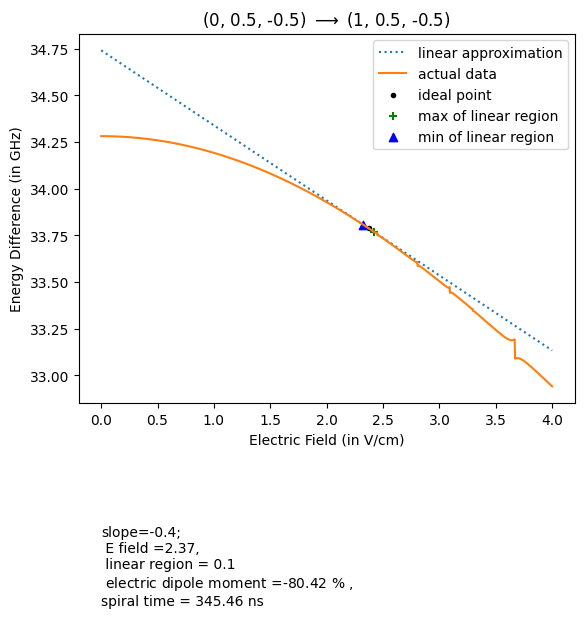

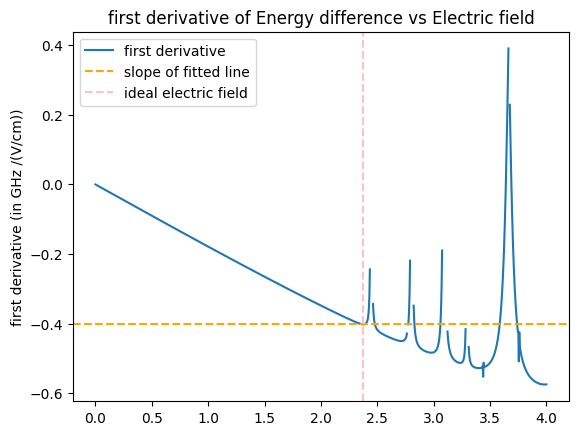

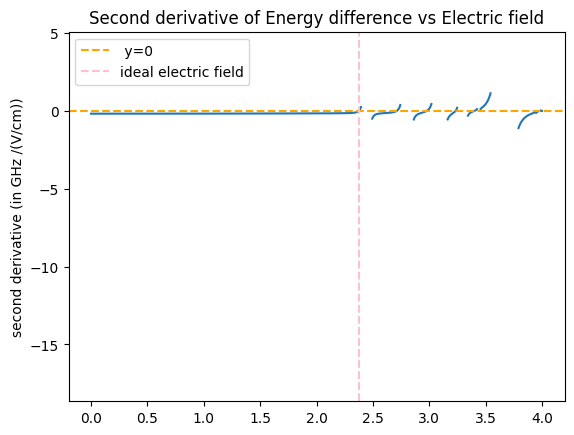

True
grndstate (48, 0, 0.5, -0.5)
excitedstate (48, 1, 0.5, 0.5)
-328.97


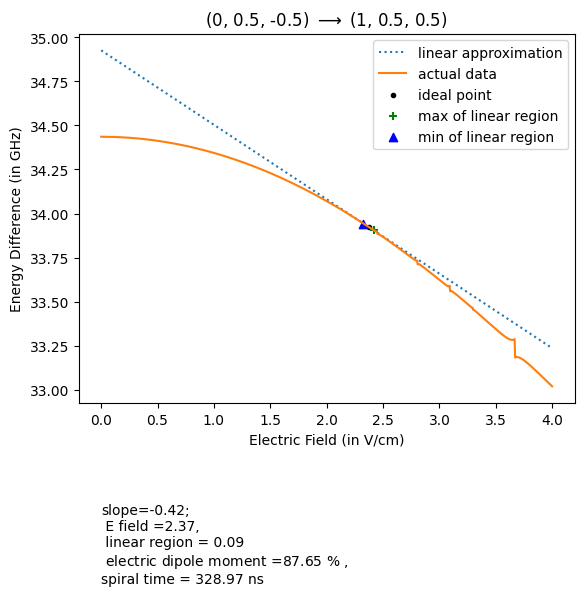

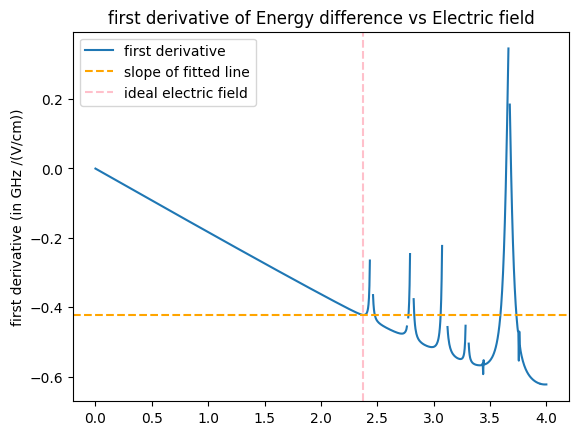

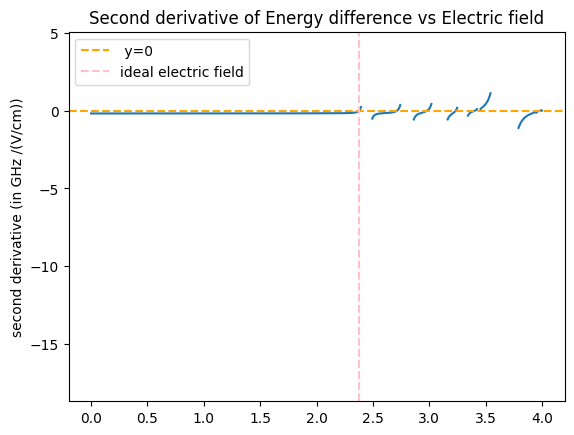

True
grndstate (48, 0, 0.5, -0.5)
excitedstate (48, 1, 1.5, -1.5)
-299.88


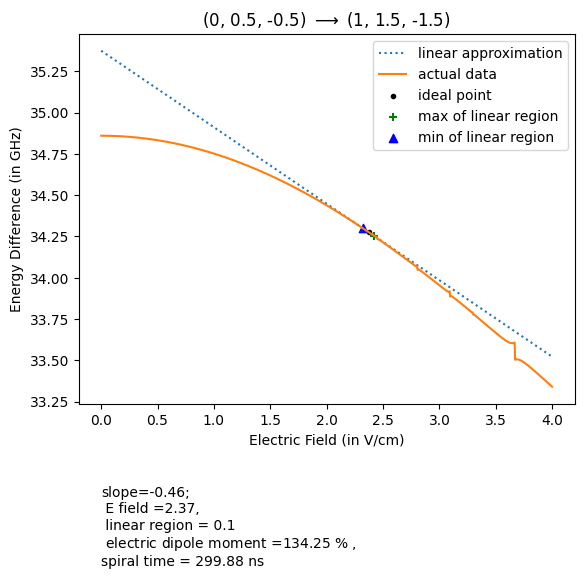

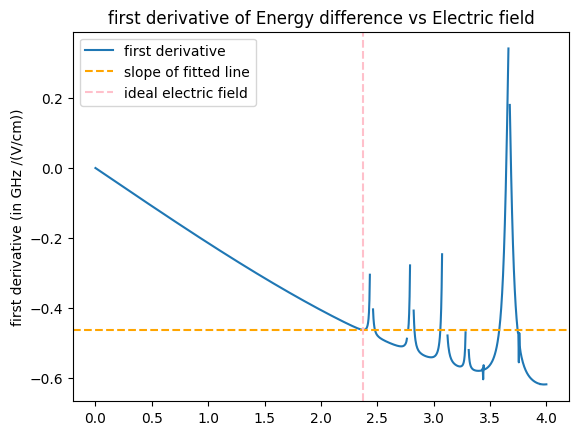

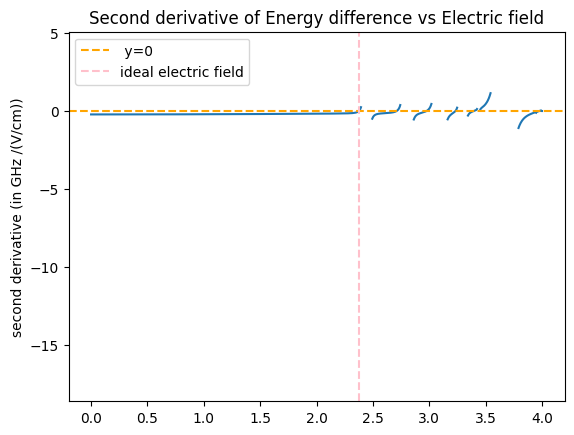

True
grndstate (48, 0, 0.5, -0.5)
excitedstate (48, 1, 1.5, -0.5)
-311.2


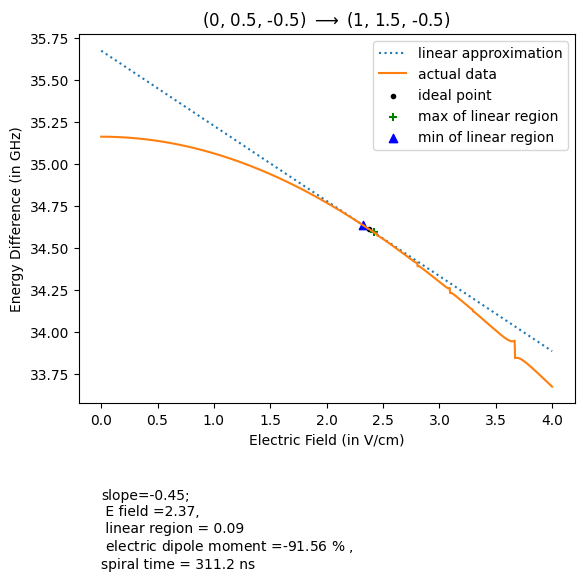

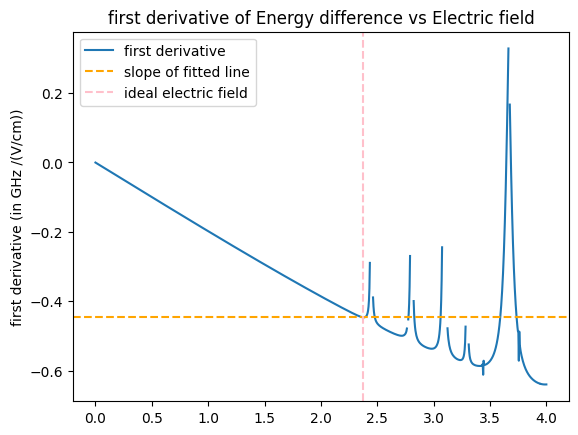

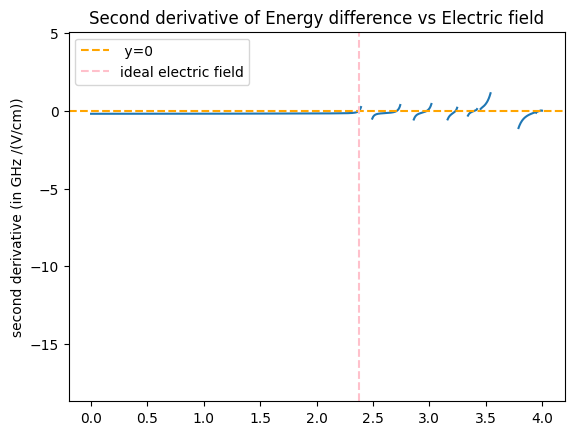

True
grndstate (48, 0, 0.5, -0.5)
excitedstate (48, 1, 1.5, 0.5)
-327.01


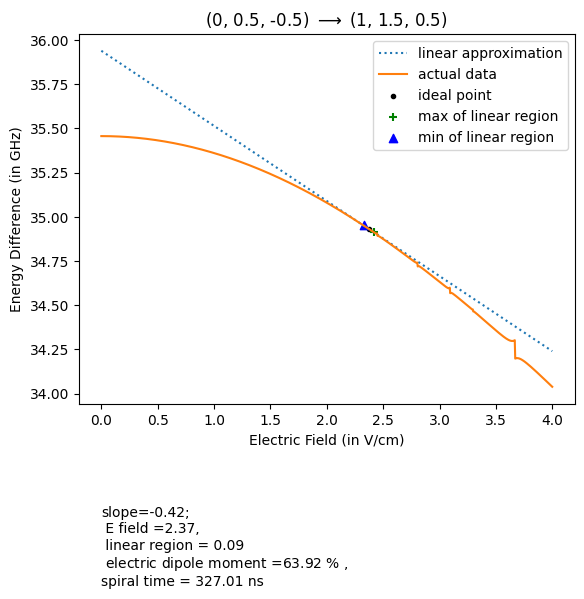

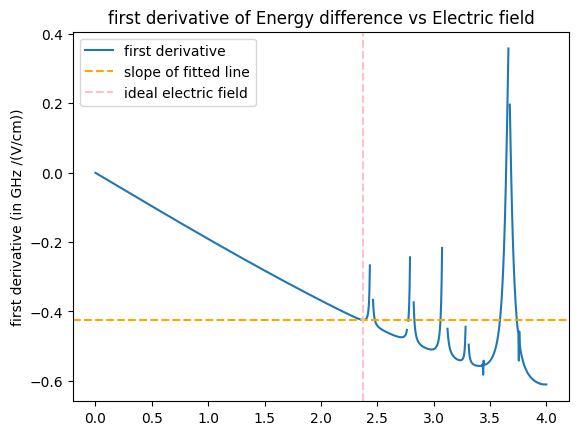

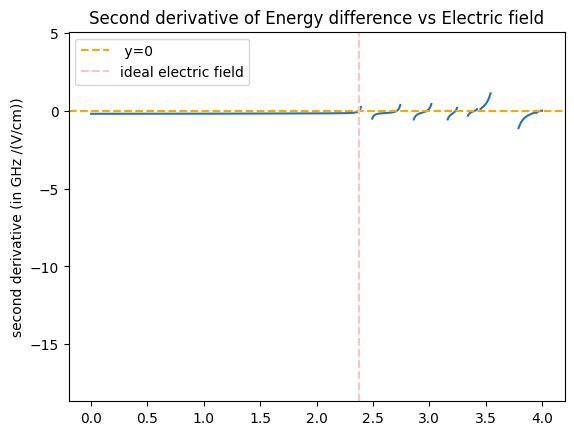

True


In [38]:
# Example
a=linear_regime_for_allowed_transitions(0,0.5,-0.5,True,preference='preferred_zero',preferred_zero=1)

# Choose the ideal transistion

The code below chooses the property requiried (given by the second index of the array a below). 


In [39]:
# Now using the obtained properties, we choose a state. Here for example, we choose a state with maximum dipole


#Choose the level with maximm electric dipole
ground_state=(0,0.5,0.5)
max_index=0
for a_index in range(0,len(a)):
    if(abs(a[a_index][9])> abs(a[max_index][9])):   # choose using  property 9,i.e. choose max electric dipole moment 
        print(abs(a[a_index][9]))
        max_index=a_index
        print(a_index)
        
        
#max_index is the index of the level to be used        
        
#OR  Can use this to set the excited level  manually
## eg. : max_index=4

87.65115841032136
1
134.2512861605019
2


Text(0, 0.5, 'energy (GHz)')

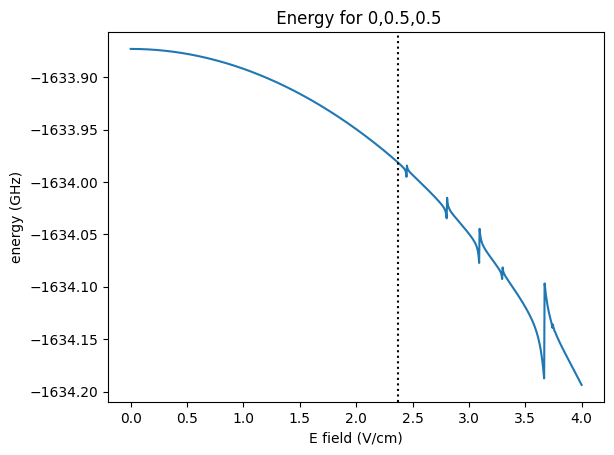

In [40]:
## Plot the energy diagram for chosen levels just to visually ensure, you are not on a crossing point:


plt.plot(array_efield,eigenstates_of_N[labels.index(ground_state)][:])
plt.axvline(x=a[max_index][4],color='k',linestyle=':')
plt.title(" Energy for 0,0.5,0.5")
plt.xlabel("E field (V/cm)")
plt.ylabel("energy (GHz)")


Text(0, 0.5, 'energy (GHz)')

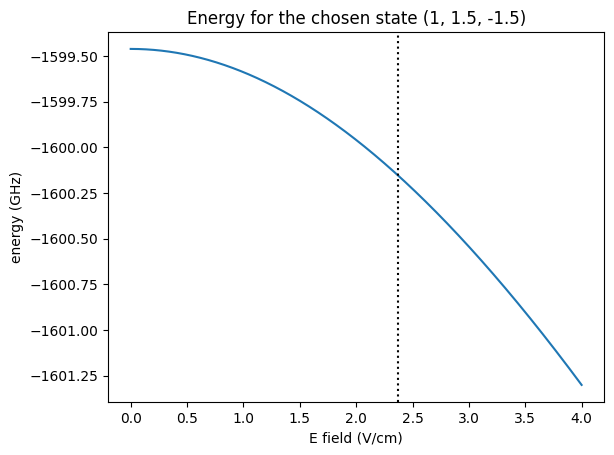

In [54]:
## Plot the energy diagram for chosen levels just to visually ensure, you are not on a crossing point:
plt.plot(array_efield,eigenstates_of_N[labels.index(a[max_index][0:3])][:])
plt.axvline(x=a[max_index][4],color='k',linestyle=':')
plt.title(f"Energy for the chosen state {a[max_index][0:3]}")

plt.xlabel("E field (V/cm)")
plt.ylabel("energy (GHz)")

Text(0, 0.5, 'energy (GHz)')

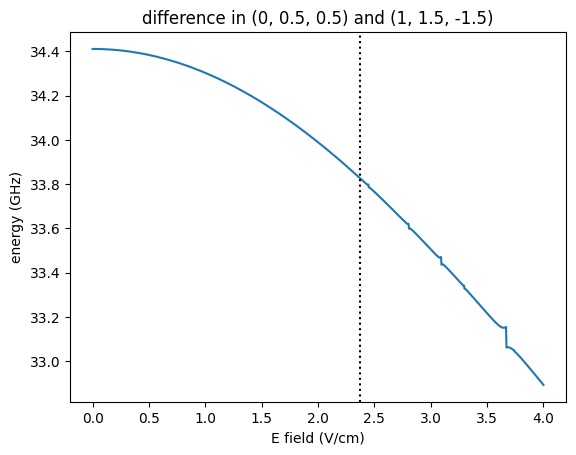

In [42]:
## Plot the energy diagram for chosen levels just to visually ensure, you are not on a crossing point:
plt.plot(array_efield,np.subtract(eigenstates_of_N[labels.index(a[max_index][0:3])],eigenstates_of_N[labels.index((0,0.5,0.5))]))
plt.axvline(x=a[max_index][4],color='k',linestyle=':')
plt.title(f"difference in {ground_state} and {a[max_index][0:3]}")

plt.xlabel("E field (V/cm)")
plt.ylabel("energy (GHz)")

# Finding pairs of other levels resonant with the same energy difference

In [43]:
# check if any other two levels  at this electric field have same energy diffrence as the ones used
# Prints the other energy levels with energy gap less than 0.1 GHZ different from energy gap of the selected levels

ground_state=(0,0.5,0.5)
optimal_E_field_index=list(array_efield).index(a[max_index][4])
energies_at_ideal_E=array_eigenvalues_1[optimal_E_field_index]
ground_state_energy=eigenstates_of_N[labels.index((ground_state))][optimal_E_field_index]
transition_frequency_optimal=a[max_index][6]
coincidental_transitions=[]

total_index_of_optimal_excited_level=labels.index((a[max_index][0],a[max_index][1],a[max_index][2]))
for energy_index in range(0,len(energies_at_ideal_E)):
    ##print(energy_index)

    delta=abs(energies_at_ideal_E[energy_index] - ground_state_energy)
    # if difference is less than 100 MHz (i.e 0.1 GHz)
    if ((abs(delta - transition_frequency_optimal)<0.1) and energy_index!=state_indices[optimal_E_field_index][total_index_of_optimal_excited_level]):
        coincidental_transitions.append(energy_index)

print("Other energy level indices resonant to the transmission frequency :",coincidental_transitions)
if(len(coincidental_transitions)!=0):
    ##plt.plot(array_efield,array_eigenvalues_1[:,coincidental_transitions[1]])
    plt.plot(array_efield,array_eigenvalues_1[:,coincidental_transitions[0]])
    plt.plot(array_efield,array_eigenvalues_1[:,coincidental_transitions[0]+1])
    plt.plot(array_efield,eigenstates_of_N[labels.index((a[max_index][0],a[max_index][1],a[max_index][2]))][:],color='k')
    plt.axvline(x=a[max_index][4],color='k',linestyle=':')
    ##plt.ylim(-1605,-1600)
  ##plt.ylim(-1603,-1602)

Other energy level indices resonant to the transmission frequency : []


# Finding C3 coefficients and mapping to Heisenberg Hamiltonian

In [44]:
# for the best chosen levels  (in the original example: 0,0.5,0.5----> 1,1.5,-1.5),
# define some place holding variables for ease of accesing the states

grnd_state_array=a[max_index][10]  # the grnd state in basis of unperturbed states
excited_state_array=a[max_index][11] # the excited state in basis of unperturbed states
up=excited_state_array 
down=grnd_state_array

# an array for ease of finding C3 matrix
two_state_array=[[up,up],[up,down],[down,up],[down,down]]


# The C3 matrix element

The Hamiltonian for Dipole-Dipole interaction has 3 terms as shown below: (on pg 8 of the reference)
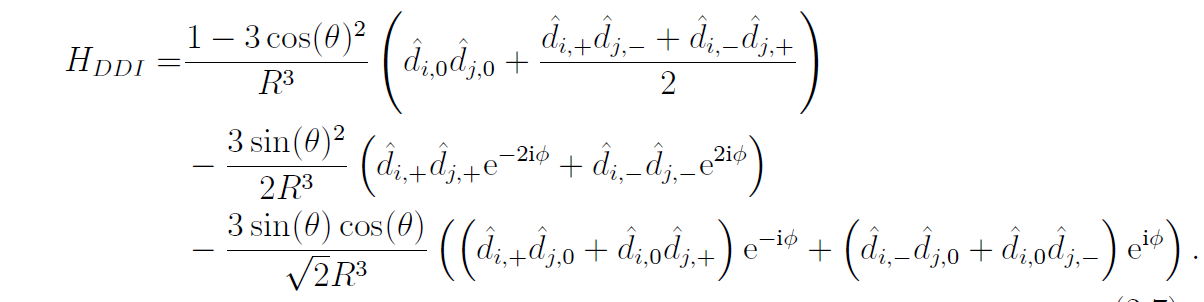


We will find matrix corresponding to each term individually below

reference: Titus Franz, Master Thesis, section 2 (2.1.1)

In [62]:
def C3_first_term(statef1_array,statef2_array,statei1_array,statei2_array): #(1-3*cos(theat)^2)/2
    
    #first is the d_i,0 d_j,0 term, added to  # <d_i,+ d_j,-> then added to # <d_i,- d_j,+>
    
    return 2*np.matmul(np.transpose(np.conjugate(statef1_array)),np.matmul(dipole_values_0,statei1_array))*\
    np.matmul(np.transpose(np.conjugate(statef2_array)),np.matmul(dipole_values_0,statei2_array)) +\
    np.matmul(np.transpose(np.conjugate(statef1_array)),np.matmul(dipole_values_plus,statei1_array))* \
    np.matmul(np.transpose(np.conjugate(statef2_array)),np.matmul(dipole_values_minus,statei2_array)) +\
    np.matmul(np.transpose(np.conjugate(statef1_array)),np.matmul(dipole_values_minus,statei1_array))* \
    np.matmul(np.transpose(np.conjugate(statef2_array)),np.matmul(dipole_values_plus,statei2_array)) 
  # Note that the factor of half in the last two terms is replaced by 2 in the first term! 

In [65]:
def C3_second_term(statef1_array,statef2_array,statei1_array,statei2_array):
    #[[d+d+],[d-d-]]
     return [np.matmul(np.transpose(np.conjugate(statef1_array)),np.matmul(dipole_values_plus,statei1_array))*\
      np.matmul(np.transpose(np.conjugate(statef2_array)),np.matmul(dipole_values_plus,statei2_array)) ,\
    np.matmul(np.transpose(np.conjugate(statef1_array)),np.matmul(dipole_values_minus,statei1_array))* \
    np.matmul(np.transpose(np.conjugate(statef2_array)),np.matmul(dipole_values_minus,statei2_array)) ]
# phases are added separately later

In [66]:
def C3_third_term(statef1_array,statef2_array,statei1_array,statei2_array):
    #[[d-d0 + d0d-],[d+d0 + d0d+]]
     return [np.matmul(np.transpose(np.conjugate(statef1_array)),np.matmul(dipole_values_minus,statei1_array))*\
      np.matmul(np.transpose(np.conjugate(statef2_array)),np.matmul(dipole_values_0,statei2_array)) + \
    np.matmul(np.transpose(np.conjugate(statef1_array)),np.matmul(dipole_values_0,statei1_array))* \
    np.matmul(np.transpose(np.conjugate(statef2_array)),np.matmul(dipole_values_minus,statei2_array)) ,
    np.matmul(np.transpose(np.conjugate(statef1_array)),np.matmul(dipole_values_plus,statei1_array))*\
      np.matmul(np.transpose(np.conjugate(statef2_array)),np.matmul(dipole_values_0,statei2_array)) + \
    np.matmul(np.transpose(np.conjugate(statef1_array)),np.matmul(dipole_values_0,statei1_array))* \
    np.matmul(np.transpose(np.conjugate(statef2_array)),np.matmul(dipole_values_plus,statei2_array)) ]

# phases are added separately later

### Using the above matrix for the 2 states chosen

Using the states vectors for the chsoen states defined earlier, and C3 matrices, add all the terms along with the $\theta$ and $\phi$ dependence

In [67]:


C3_first_term_matrix=np.zeros(shape=(4,4))
C3_second_term_matrix_minus_phi=np.zeros(shape=(4,4))
C3_second_term_matrix_plus_phi=np.zeros(shape=(4,4))
C3_third_term_matrix_plus_phi=np.zeros(shape=(4,4))
C3_third_term_matrix_minus_phi=np.zeros(shape=(4,4))

C3_net_matrix=np.zeros(shape=(4,4))
for i1 in range(len(C3_net_matrix)):
    for i2 in range(len(C3_net_matrix[0])):
        C3_first_term_matrix[i1][i2]=C3_first_term(two_state_array[i1][0],two_state_array[i1][1],\
                                                   two_state_array[i2][0],two_state_array[i2][1])
        
       # print(C3_second_term(two_state_array[i1][0],two_state_array[i1][1],\
                                                   #two_state_array[i2][0],two_state_array[i2][1])[0])
        
        C3_second_term_matrix_plus_phi[i1][i2]=C3_second_term(two_state_array[i1][0],two_state_array[i1][1],\
                                                   two_state_array[i2][0],two_state_array[i2][1])[0]
        
        C3_second_term_matrix_minus_phi[i1][i2]=C3_second_term(two_state_array[i1][0],two_state_array[i1][1],\
                                                   two_state_array[i2][0],two_state_array[i2][1])[1]
        
        C3_third_term_matrix_plus_phi[i1][i2]=C3_third_term(two_state_array[i1][0],two_state_array[i1][1],\
                                                   two_state_array[i2][0],two_state_array[i2][1])[0]
        
        C3_third_term_matrix_minus_phi[i1][i2]=C3_third_term(two_state_array[i1][0],two_state_array[i1][1],\
                                                   two_state_array[i2][0],two_state_array[i2][1])[0]




In [68]:
def C3_net(theta,phi):
    return    ((1-3*np.cos(theta)**2)/2)* C3_first_term_matrix \
    -(3*np.sin(theta)**2)/2 *(np.e**(-2*iota*phi)* C3_second_term_matrix_plus_phi  \
                             + np.e**(2*iota*phi)* C3_second_term_matrix_minus_phi  )\
    -3*np.sin(2*theta)/(2*np.sqrt(2))*(np.e**(iota*phi)* C3_third_term_matrix_plus_phi  \
                             - np.e**(-iota*phi)* C3_third_term_matrix_minus_phi  )

# Mapping to a Heisenberg Hamiltonian

As per the mapping done below (pg 16 of reference), using the C3 coefficients, we can find the coefficients in the spin-spin interaction Hamiltonian

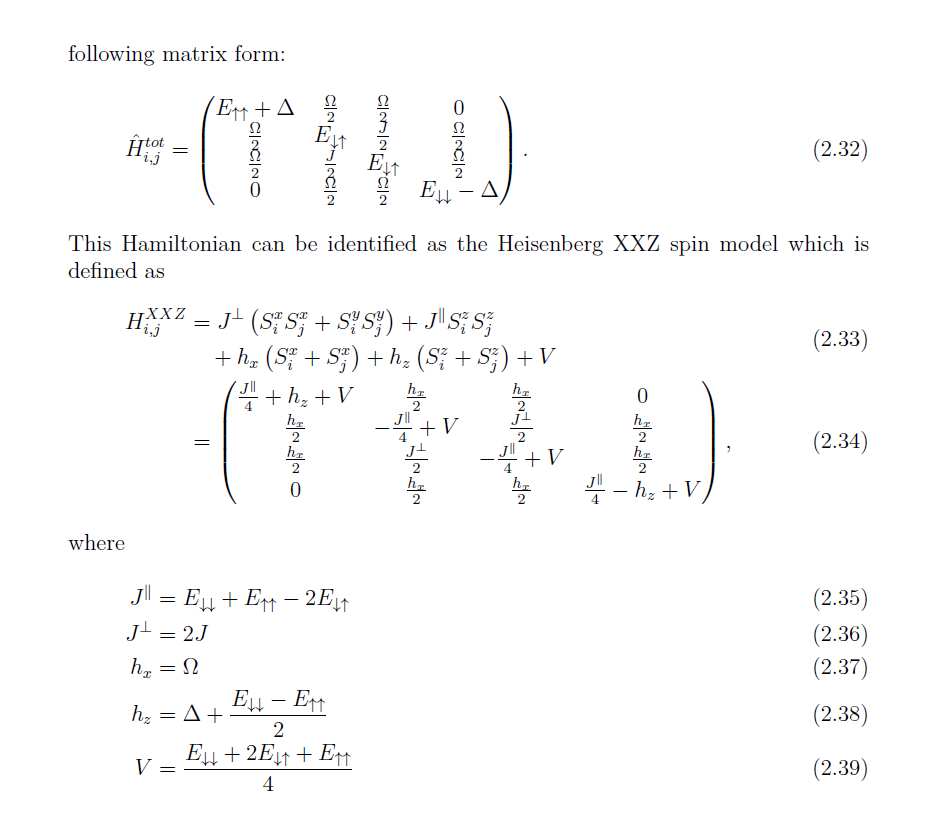


We then find variation of the J coefficients with direction i.e $\theta$ and $\phi$ 

In [69]:
# Directional dependence of J_parallel and J_perpendicular and other coefficients in the Hamiltonian:


theta_range=np.linspace(0,np.pi,180)
phi_range=np.linspace(0,2*np.pi,360)
J_perp = np.zeros(shape=(len(theta_range),len(phi_range)),dtype=np.complex_)
J_parallel = np.zeros(shape=(len(theta_range),len(phi_range)),dtype=np.complex_)
h_z=np.zeros(shape=(len(theta_range),len(phi_range)),dtype=np.complex_)
V=np.zeros(shape=(len(theta_range),len(phi_range)),dtype=np.complex_)
for theta_index in range(len(theta_range)):
    for phi_index in range(len(phi_range)):
        C3_temp=C3_net(theta_range[theta_index],phi_range[phi_index])
        #J_par_1= 2*(C3_temp[0][0] + C3_temp[3][3])
        #J_par_2= -4*(C3_temp[1][1])
        #print(abs(J_par_1-J_par_2)<10**-3)
        J_parallel[theta_index][phi_index]=(C3_temp[0][0] + C3_temp[3][3])-(C3_temp[1][1] + C3_temp[2][2])
        V[theta_index][phi_index]=(C3_temp[0][0] + C3_temp[3][3]+C3_temp[1][1] + C3_temp[2][2])/4
        J_perp[theta_index][phi_index]=2*C3_temp[1][2]
        #print(2*C3_temp[1][2])
        h_z[theta_index][phi_index]=(C3_temp[0][0]-C3_temp[3][3])/2
 



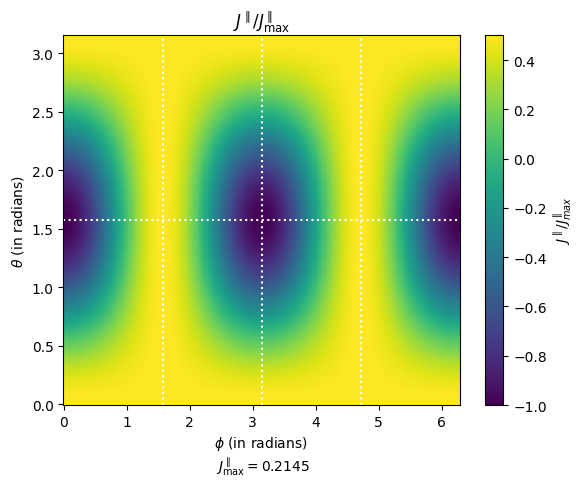

In [72]:
pc=plt.pcolormesh(phi_range,theta_range,J_parallel.real/np.max(abs(J_parallel.real)))
plt.xlabel(f"$ \phi $ (in radians) \n $J^\parallel_\max={np.round(abs(np.max(J_parallel.real)),4)}$")
plt.ylabel(r"$ \theta $ (in radians)")
plt.title(f"$J^\parallel / J^\parallel_\max $")
colorbar=plt.colorbar(pc)

plt.axhline(y=np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=3*np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=np.pi,linestyle='dotted',color='white')

colorbar.set_label("$ J^{\parallel}/J^{\parallel}_{max} $")


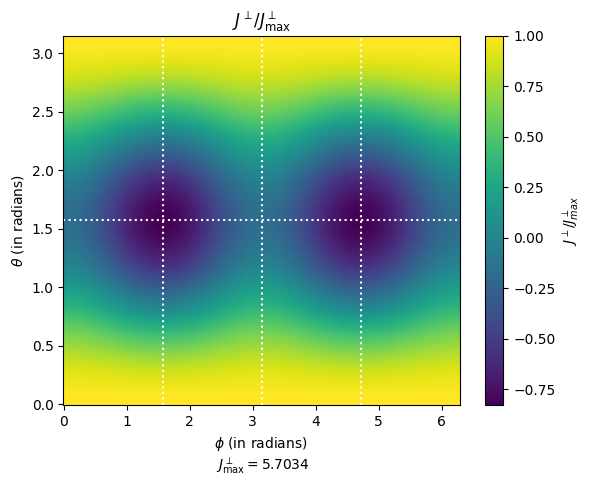

In [73]:
pc=plt.pcolormesh(phi_range,theta_range,J_perp.real/np.max(abs(J_perp.real)))
plt.xlabel(f"$ \phi $ (in radians) \n $J^\perp_\max={np.round(abs(np.max(J_perp.real)),4)}$")
plt.ylabel(r"$ \theta $ (in radians)")
plt.title(f"$J^\perp / J^\perp_\max $")
colorbar=plt.colorbar(pc)

plt.axhline(y=np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=3*np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=np.pi,linestyle='dotted',color='white')

colorbar.set_label("$ J^{\perp}/J^{\perp}_{max} $")


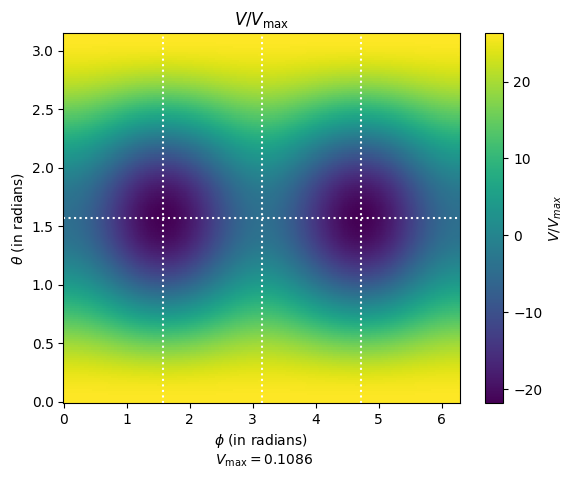

In [74]:
pc=plt.pcolormesh(phi_range,theta_range,J_perp.real/np.max(abs(V.real)))
plt.xlabel(f"$ \phi $ (in radians) \n $V_\max={np.round(abs(np.max(V.real)),4)}$")
plt.ylabel(r"$ \theta $ (in radians)")
plt.title("$V / V_{\max} $")
colorbar=plt.colorbar(pc)

plt.axhline(y=np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=3*np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=np.pi,linestyle='dotted',color='white')

colorbar.set_label("$ V/V_{max} $")

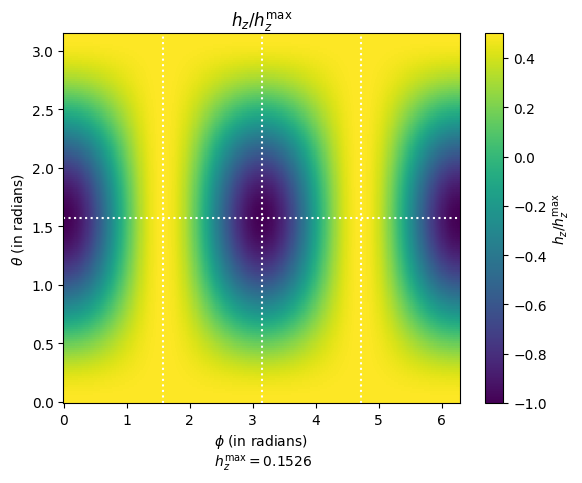

In [77]:
pc=plt.pcolormesh(phi_range,theta_range,h_z.real/(np.max(abs(h_z.real))))
plt.xlabel(f"$ \phi $ (in radians) \n $h_z^\max={np.round(abs(np.max(h_z.real)),4)}$")
plt.ylabel(r"$ \theta $ (in radians)")
plt.title(f"$h_z/ h_z^\max $")
colorbar=plt.colorbar(pc)

plt.axhline(y=np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=3*np.pi/2,linestyle='dotted',color='white')
plt.axvline(x=np.pi,linestyle='dotted',color='white')

colorbar.set_label("$ h_z/h_z^\max$")

In [78]:
x_=np.kron(np.sin(theta_range),np.cos(phi_range))
y_=np.kron(np.sin(theta_range),np.sin(phi_range))
z_=np.kron(np.cos(theta_range),np.full(shape=len(phi_range),fill_value=1))


# Creating 3d Plots and GIFs

Interpretation of plots: We plot the normalized magnitude of the coefficients (normalized wrt their maximum value) in a given direction. 
So a point far away from origin in a drection means the coefficient is large in that direction. The sign is color-coded 
    

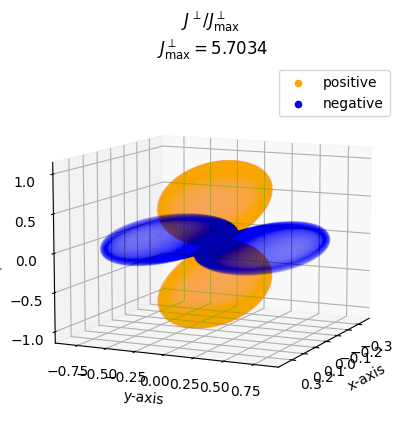

In [80]:
# J_perp in 3D


ax = plt.axes(projection='3d') 
x_plot=np.multiply(abs(J_perp.real).flatten(),x_)/np.max(abs(J_perp.real))
y_plot=np.multiply(abs(J_perp.real).flatten(),y_)/np.max(abs(J_perp.real))
z_plot=np.multiply(abs(J_perp.real).flatten(),z_)/np.max(abs(J_perp.real))
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.set_title(f"$J^\perp / J^\perp_\max$ \n $J^\perp _\max = {np.round(np.max(abs(J_perp.real)),4)}$")
ax.scatter3D(x_plot[J_perp.real.flatten()>0],y_plot[J_perp.real.flatten()>0],z_plot[J_perp.real.flatten()>0],alpha=0.01,color='orange')
ax.scatter3D(x_plot[J_perp.real.flatten()<0],y_plot[J_perp.real.flatten()<0],z_plot[J_perp.real.flatten()<0],alpha=0.01,color='blue')
ax.scatter3D(0,0,0,color='orange',label='positive')
ax.scatter3D(0,0,0,color='blue',label='negative')

plt.legend()
ax.view_init(elev=10, azim=25)
# To create GIFs, uncomment below, this will save the frames. Then run the "Create GIF" block with appropriate picture names
##for azim in range(0,200,10):
        ##ax.view_init(elev=10., azim=azim)
        ## plt.savefig("j_per_gif%d.png" % azim)

##z_plot_minus=z_plot[J_perp.real.flatten()<0]
##x_plot_minus=x_plot[J_perp.real.flatten()<0]
##y_plot_minus=y_plot[J_perp.real.flatten()<0]
##ax.scatter3D(x_plot_minus,y_plot_minus,z_plot_minus,alpha=0.01,color='blue',label='negative')
##ax.plot_surface(x_plot,y_plot,)
plt.show()




Text(0.5, 0, 'x axis')

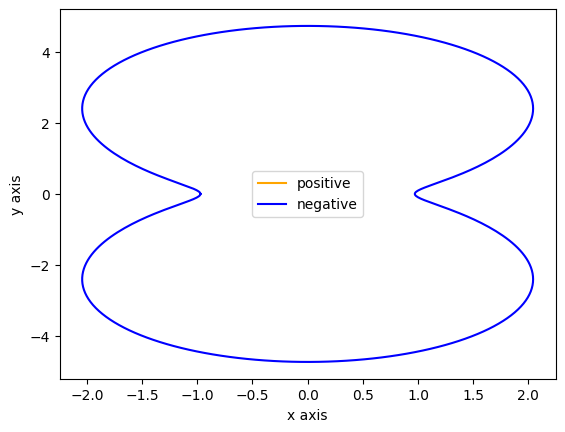

In [121]:
#Plotting a 2D contour in x-y plane
# i.e. at theta=90
plt.plot(np.multiply(J_perp[89].real,np.cos(phi_range))[J_perp[89].real>0],np.multiply(J_perp[89].real,np.sin(phi_range))[J_perp[89].real>0],color='orange',label='positive' )

plt.plot(np.multiply(J_perp[89].real,np.cos(phi_range))[J_perp[89].real<0],np.multiply(J_perp[89].real,np.sin(phi_range))[J_perp[89].real<0],color='blue' ,label='negative')
plt.legend()
plt.ylabel("y axis")
plt.xlabel("x axis")


In [ ]:
# Create GIF

import imageio
frames = []
for azim in range(0,200,10):
    image = imageio.v2.imread("j_per_gif%d.png" % azim)
    frames.append(image)
imageio.mimsave('./j_per_final_gif.gif', # output gif
                frames,          # array of input frames
                duration = 200) 

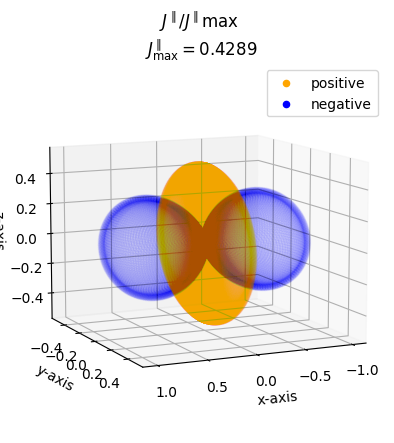

In [91]:
# J_parallel in 3D
ax = plt.axes(projection='3d') 
x_plot=np.multiply(abs(J_parallel.real).flatten(),x_)/np.max(abs(J_parallel.real))
y_plot=np.multiply(abs(J_parallel.real).flatten(),y_)/np.max(abs(J_parallel.real))
z_plot=np.multiply(abs(J_parallel.real).flatten(),z_)/np.max(abs(J_parallel.real))

ax.scatter3D(x_plot[J_parallel.real.flatten()>0],y_plot[J_parallel.real.flatten()>0],z_plot[J_parallel.real.flatten()>0],alpha=0.01,color='orange')
ax.scatter3D(x_plot[J_parallel.real.flatten()<0],y_plot[J_parallel.real.flatten()<0],z_plot[J_parallel.real.flatten()<0],alpha=0.01,color='blue')
ax.scatter3D(0,0,0,color='orange',label='positive')
ax.scatter3D(0,0,0,color='blue',label='negative')

plt.legend()
ax.view_init(elev=10, azim=65)
ax.set_title(f"$J^\parallel / J^\parallel\max$ \n $J^\parallel _\max = {np.round(np.max(abs(J_parallel.real)),4)}$")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
#for azim in range(0,200,10):
        #ax.view_init(elev=10., azim=azim)
        #plt.savefig("j_par_gif%d.png" % azim)

#z_plot_minus=z_plot[J_perp.real.flatten()<0]
#x_plot_minus=x_plot[J_perp.real.flatten()<0]
#y_plot_minus=y_plot[J_perp.real.flatten()<0]
#ax.scatter3D(x_plot_minus,y_plot_minus,z_plot_minus,alpha=0.01,color='blue',label='negative')
#ax.plot_surface(x_plot,y_plot,)
plt.show()




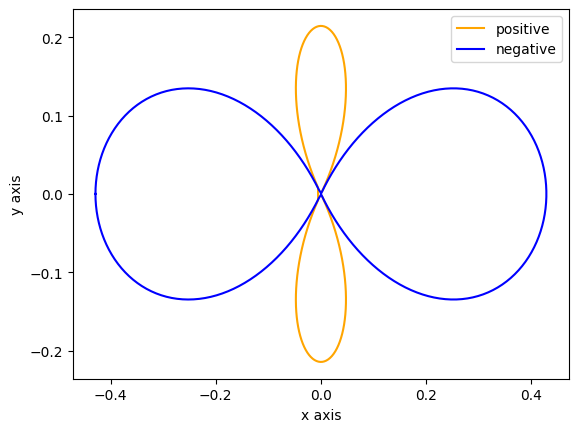

In [122]:
#Plotting a 2D contour in x-y plane
# i.e. at theta=90
plt.plot(np.multiply(J_parallel[89].real,np.cos(phi_range))[J_parallel[89].real>0],np.multiply(J_parallel[89].real,np.sin(phi_range))[J_parallel[89].real>0],color='orange',label='positive' )

plt.plot(np.multiply(J_parallel[89].real,np.cos(phi_range))[J_parallel[89].real<0],np.multiply(J_parallel[89].real,np.sin(phi_range))[J_parallel[89].real<0],color='blue',label='negative' )

plt.ylabel("y axis")
plt.xlabel("x axis")

plt.legend()


In [ ]:
# Create GIF
import imageio
frames = []
for azim in range(0,200,10):
    image = imageio.v2.imread("j_par_gif%d.png" % azim)
    frames.append(image)
imageio.mimsave('./j_par_final_gif.gif', # output gif
                frames,          # array of input frames
                duration = 200)         # optional: frames per second

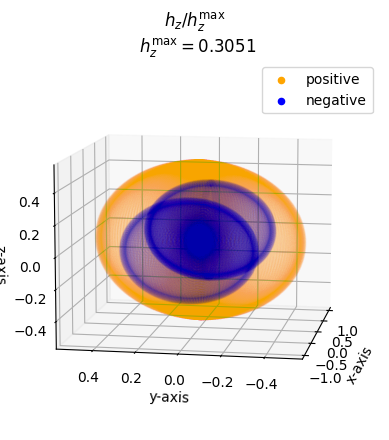

In [82]:
# h_z in 3d

ax = plt.axes(projection='3d') 
x_plot=np.multiply(abs(h_z.real).flatten(),x_)/np.max(abs(h_z.real))
y_plot=np.multiply(abs(h_z.real).flatten(),y_)/np.max(abs(h_z.real))
z_plot=np.multiply(abs(h_z.real).flatten(),z_)/np.max(abs(h_z.real))
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
ax.set_title(f"$h_z / h_z^\max$ \n $h_z^\max = {np.round(np.max(abs(h_z.real)),4)}$")
ax.scatter3D(x_plot[h_z.real.flatten()>0],y_plot[h_z.flatten()>0],z_plot[h_z.flatten()>0],alpha=0.01,color='orange')
ax.scatter3D(x_plot[h_z.flatten()<0],y_plot[h_z.flatten()<0],z_plot[h_z.real.flatten()<0],alpha=0.01,color='blue')
ax.scatter3D(0,0,0,color='orange',label='positive')
ax.scatter3D(0,0,0,color='blue',label='negative')

plt.legend()
#ax.view_init(elev=10, azim=80)


for azim in range(0,200,10):
        ax.view_init(elev=10., azim=azim)
        plt.savefig("h_z_gif%d.png" % azim)

#z_plot_minus=z_plot[J_perp.real.flatten()<0]
#x_plot_minus=x_plot[J_perp.real.flatten()<0]
#y_plot_minus=y_plot[J_perp.real.flatten()<0]
#ax.scatter3D(x_plot_minus,y_plot_minus,z_plot_minus,alpha=0.01,color='blue',label='negative')
#ax.plot_surface(x_plot,y_plot,)
plt.show()




In [83]:
# Create GIF
import imageio
frames = []
for azim in range(0,200,10):
    image = imageio.v2.imread("h_z_gif%d.png" % azim)
    frames.append(image)
imageio.mimsave('./h_z.gif', # output gif
                frames,          # array of input frames
                duration = 200)         # optional: frames per second

In [ ]:
plt.plot()